Python environment

In [ ]:
import os
from pathlib import Path
import pickle

import scanpy as sc
import anndata

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotnine as p9

from tqdm.auto import tqdm
from sklearn.metrics import adjusted_rand_score

from io import StringIO

In [ ]:
sc.set_figure_params(dpi=100, dpi_save = 300, color_map = 'viridis_r')
sc.settings.verbosity = 1
sc.logging.print_header()
plt.rcParams['pdf.fonttype'] = 42
sc.settings.figdir = 'figures'

scanpy==1.9.0.dev1+g87396a8 anndata==0.7.5 umap==0.5.1 numpy==1.20.2 scipy==1.6.2 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.9.1 louvain==0.7.0 leidenalg==0.8.3 pynndescent==0.5.2


In [ ]:
import matplotlib as mpl
# https://github.com/theislab/scanpy/issues/1720
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [ ]:
sc.settings.n_jobs = 8

In [ ]:
import sys

sys.path.append(str(Path.home() / 'Code/sctoolkit/')) # PATH home /home/pmc_research/cmoreno

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import functools
import scipy.sparse as sp 

def py2r(x):
    '''Convert a Python object to an R object using rpy2'''
    import rpy2.robjects as ro
    from rpy2.robjects import numpy2ri, pandas2ri
    from rpy2.robjects.conversion import localconverter
    import anndata2ri

    if sp.issparse(x):
        # workaround for: https://github.com/theislab/anndata2ri/issues/47
        return anndata2ri.scipy2ri.py2rpy(x)

    with localconverter(
        ro.default_converter + numpy2ri.converter + pandas2ri.converter
    ):
        x = ro.conversion.py2rpy(x)

    return x

def r2py(x):
    '''Convert an rpy2 (R)  object to a Python object'''
    import rpy2.robjects as ro
    from rpy2.robjects import numpy2ri, pandas2ri
    from rpy2.robjects.conversion import localconverter
    import anndata2ri

    try:
        with localconverter(
            ro.default_converter
            + numpy2ri.converter
            + pandas2ri.converter
            + anndata2ri.scipy2ri.converter
        ):
            x = ro.conversion.rpy2py(x)

    except TypeError:
        # workaround for: https://github.com/theislab/anndata2ri/issues/47
        x = anndata2ri.scipy2ri.rpy2py(x)

    return x

In [ ]:
# from .rtools import r2py, py2r
# from .utils import bin_pval

import logging
import numpy as np
import pandas as pd
from plotnine import *
from plotnine.data import diamonds as ddata
import matplotlib.gridspec as gridspec


def get_proportions_per_channel(adata, sample_key, proportion_key, covariates=None, groups=None):

    if groups is not None:
        adata = adata[adata.obs[proportion_key].isin(groups)]

    prop_df = pd.DataFrame(adata.obs.groupby([sample_key, proportion_key]).size(), columns=['ncell']).reset_index()

    prop_df = prop_df.pivot(index=sample_key, columns=proportion_key, values='ncell').fillna(0)
    prop_df.columns.name = None
    prop_df.columns = prop_df.columns.astype(str)
    prop_df /= prop_df.sum(1).values[:, None]
    prop_df.index = prop_df.index.astype(str)

    if covariates is not None:
        assert np.all(np.isin(covariates, adata.obs.columns))

        # check if all categoricals are nested in sample_key
        cat_covariates = [x for x in covariates if adata.obs[x].dtype.kind not in 'biufc']
        if cat_covariates:
            assert len(adata.obs[[sample_key] + cat_covariates].drop_duplicates()) == adata.obs[sample_key].nunique()

        covar_df = adata.obs.groupby(sample_key)[covariates].agg(**{x: pd.NamedAgg(x, 'first') if x in cat_covariates else pd.NamedAgg(x, 'mean') for x in covariates})
        covar_df = covar_df.loc[prop_df.index.values]
        covar_df.index = covar_df.index.astype(str)

        for c in cat_covariates:
            if adata.obs[c].dtype.name == 'category':
                covar_df[c] = pd.Categorical(covar_df[c], categories=adata.obs[c].cat.categories)

        assert np.all(prop_df.index == covar_df.index)

        return prop_df, covar_df
    else:
        return prop_df



def dirichletreg(adata, sample_key, proportion_key, covariates, formula, onevsrest_category=None, return_reg_input=False):
    adata._sanitize()
    prop_df, covar_df = get_proportions_per_channel(adata, sample_key, proportion_key, covariates)
    return dirichletreg_df(prop_df, covar_df, formula, onevsrest_category=onevsrest_category, return_reg_input=return_reg_input)


def dirichletreg_df(prop_df, covar_df, formula, onevsrest_category=None, return_reg_input=False):
    from rpy2.robjects import r, Formula
    from rpy2.robjects.packages import importr
    from rpy2.rinterface_lib.callbacks import logger as rpy2_logger

    dr = importr('DirichletReg')
    dr_df = pd.concat([prop_df, covar_df], axis=1)

    f = Formula(formula)

    rpy2_logger.setLevel(logging.ERROR)   # will display errors, but not warnings
    f.environment['y'] = dr.DR_data(py2r(prop_df))
    rpy2_logger.setLevel(logging.WARNING)   # will display errors, but not warnings

    if onevsrest_category is None:
        fit = dr.DirichReg(f, py2r(dr_df))
    else:
        assert onevsrest_category in prop_df.columns
        cat_index = prop_df.columns.tolist().index(onevsrest_category) + 1
        fit = dr.DirichReg(f, py2r(dr_df), model='alternative', **{'sub.comp': cat_index})

    r.sink(file='/dev/null')
    u = r.summary(fit)
    r.sink()
    if r('sink.number')()[0]>0:
        r.sink()

    if onevsrest_category is None:
        varnames = u.rx2('varnames')
    else:
        varnames = [onevsrest_category] * 2

    coef_mat = u.rx2('coef.mat')
    rows = r2py(r('rownames')(coef_mat))
    coef_df = r2py(r('as.data.frame')(coef_mat)).reset_index(drop=True)
    coef_df.columns = ['coefficient', 'se', 'zval', 'pval']

    coef_df['compartment'] = np.repeat(varnames, r2py(u.rx2('n.vars')))
    coef_df['variable'] = rows
    coef_df['significance'] = bin_pval(coef_df.pval)

    if onevsrest_category is not None:
        coef_df['coef_type'] = np.repeat(['mean', 'precision'], r2py(u.rx2('n.vars')))

    if return_reg_input:
        return dr_df, coef_df
    else:
        return coef_df


def plot_proportion_barplot(
    adata,
    yaxis,
    fill, 
    fill_breakdown=None,
    yaxis_label=None,
    y_label_func=None,
    xaxis_label='Proportions',
    fill_label=None,
    percent_limit=5., 
    show_percent=True,
    height_scale=1., 
    width_scale=1.,
    legend_position=None,
    return_df=False,
    normalize_by=None,
    format_x_as_percent=True,
    remove_x_axis_ticks=False,
    swap_axes=False,
    external_percent_label=None,
    bar_position='fill',
    fill_groups=None,
):

    import mizani
    import matplotlib.patheffects as pe

    if yaxis_label is None: yaxis_label = yaxis
    if fill_label is None: fill_label = fill

    adata._sanitize()

    fill_dict = {k:v for k,v in zip(adata.obs[fill].cat.categories, adata.uns[f'{fill}_colors'])}

    groupby = [yaxis, fill] + ([external_percent_label] if external_percent_label is not None else [])
    if fill_breakdown is not None and (fill_breakdown not in groupby):
        groupby.append(fill_breakdown)
    if normalize_by is not None and (normalize_by not in groupby):
        print('normalizing by a factor that is not plotted, please make sure you want to do that.')
        groupby.append(normalize_by)

    df_level1 = pd.DataFrame(adata.obs.groupby(groupby, observed=True).size(), columns=['counts'])

    if normalize_by:
        scales = df_level1.reset_index().groupby(normalize_by)[['counts']].sum()
        scales = scales.sum().div(scales)

        df_level1 = df_level1.multiply(scales)

    df_level0 = df_level1.reset_index().groupby(yaxis)[['counts']].sum()
    df = df_level1.div(df_level0, level=yaxis).reset_index()
    
    df[fill]  = pd.Categorical(df[fill], categories=reversed(adata.obs[fill].cat.categories))
    if swap_axes: #do not reverse order if swap_axes is given
        rev_func = lambda x: x
    else:
        rev_func = reversed
    df[yaxis] = pd.Categorical(df[yaxis], categories=rev_func(adata.obs[yaxis].cat.categories))

    df['counts_coarse'] = df.groupby([yaxis, fill], observed=True)['counts'].transform('sum')
    df['counts_coarse_round_percent'] = (df.counts_coarse*100).round().astype(int)

    df['_show_text'] = df.counts_coarse_round_percent >= percent_limit
    df['_show_breakdown'] = (df.counts_coarse_round_percent >= percent_limit) if fill_breakdown else False
        
    # collapse breakdown of small groups
    if fill_breakdown:
        df = df[(~df.duplicated([yaxis, fill])) | (df._show_breakdown)].copy()
        df.loc[~df._show_breakdown, 'counts'] = df.loc[~df._show_breakdown, 'counts_coarse']
        df['_show_breakdown'] = True
        
    cs = df.sort_values([yaxis, fill], ascending=False).drop_duplicates([yaxis, fill]).groupby(yaxis, observed=True)['counts_coarse'].transform(pd.Series.cumsum)
    df['cumsum_mean'] = cs - df['counts_coarse'] + (df['counts_coarse']/2)        

    figure_width = 8*width_scale
    figure_height = 0.4*df[yaxis].nunique()*height_scale

    if swap_axes:
        figure_width, figure_height = figure_height, figure_width

    g = (
        ggplot(aes(x=yaxis, y='counts', fill=fill, group=fill), data=df[df[fill].isin(fill_groups)] if fill_groups is not None else df) +
        geom_bar(position=bar_position, stat='identity', mapping=aes(color='_show_breakdown'), size=0.08) +
        (scale_y_continuous(labels=mizani.formatters.percent) if format_x_as_percent else geom_blank()) +
        (scale_x_discrete(labels=y_label_func) if y_label_func is not None else geom_blank()) +
        (coord_flip() if not swap_axes else geom_blank()) +
        theme_minimal() +
        theme(
            text=element_text(family="Arial"),
            figure_size=(figure_width, figure_height),
            legend_position=legend_position,
            axis_text_x=element_blank() if remove_x_axis_ticks else element_text(angle=90 if swap_axes else 0), 
            axis_ticks_major_x=element_blank() if remove_x_axis_ticks else None, 
            axis_ticks_minor_x=element_blank() if remove_x_axis_ticks else None, 
            panel_grid_major=element_blank(), panel_grid_minor=element_blank(),
            ) + 
        scale_color_manual(values={True: 'black', False: 'none'}) +
        scale_fill_manual(values=fill_dict) +        
        labs(x=yaxis_label, y=xaxis_label, fill=fill_label) +
        guides(fill = guide_legend(reverse=True), color=None)
    )

    if show_percent:
        if external_percent_label is not None:
            label = external_percent_label
        else:
            label = 'counts_coarse_round_percent'
        g += geom_text(aes(label=label, y='cumsum_mean'), data=df[df._show_text],
                  color='white', size=8, fontweight='bold',
                  path_effects=(pe.Stroke(linewidth=1, foreground='black'), pe.Normal()))

    if return_df:
        return g, df
    else:
        return g

    
def plot_proportion_barplot_cellcounts(
    adata,
    yaxis,
    height_scale=1., 
    width_scale=1.,
    legend_position=None,
):

    import mizani
    import matplotlib.patheffects as pe
    
    adata._sanitize()

    df = pd.DataFrame(adata.obs.groupby([yaxis], observed=True).size(), columns=['ncell']).reset_index()
    df['counts'] = 1
    df[yaxis] = pd.Categorical(df[yaxis], categories=reversed(adata.obs[yaxis].cat.categories))    
    

    g = (
        ggplot(aes(x=yaxis, y='counts', fill='ncell.astype(float)'), data=df) +
        geom_col() +
        coord_flip() +
        theme_minimal() +
        theme(figure_size=(1.*width_scale, 
                           0.4*df[yaxis].nunique()*height_scale),
              axis_text_y=element_blank(),
              axis_text_x=element_blank(),
              text=element_text(family="Arial"),
              axis_ticks_major_x=element_blank(), 
              axis_ticks_minor_x=element_blank(), 
              panel_grid_major=element_blank(),
              panel_grid_minor=element_blank(),
              legend_position=legend_position) +  
        labs(x=None, y='Cell counts', fill='Cell counts') +
        geom_text(aes(label='ncell', y=0.5),
                  color='white', size=8, fontweight='bold',
                  path_effects=(pe.Stroke(linewidth=1, foreground='black'), pe.Normal())) + 
        scale_fill_continuous(trans='log10', cmap_name='plasma', limits=(1, df.ncell.astype(float).max()))
    )

    return g


def plot_proportion_barplot_single_categorical(
    adata,
    yaxis,
    fill,
    height_scale=1., 
    width_scale=1.,
    legend_position=None,
):

    import mizani
    import matplotlib.patheffects as pe
    
    adata._sanitize()

    fill_dict = {k:v for k,v in zip(adata.obs[fill].cat.categories, adata.uns[f'{fill}_colors'])}
    
    df = adata.obs[[yaxis, fill]].drop_duplicates().reset_index()
    df['counts'] = 1
    df[yaxis] = pd.Categorical(df[yaxis], categories=reversed(adata.obs[yaxis].cat.categories))    

    g = (
        ggplot(aes(x=yaxis, y='counts', fill=fill), data=df) +
        geom_col() +
        coord_flip() +
        theme_minimal() +
        theme(figure_size=(1.*width_scale, 
                           0.4*df[yaxis].nunique()*height_scale),
              axis_text_y=element_blank(),
              axis_text_x=element_blank(),
              text=element_text(family="Arial"),
              axis_ticks_major_x=element_blank(), 
              axis_ticks_minor_x=element_blank(), 
              panel_grid_major=element_blank(),
              panel_grid_minor=element_blank(),
              legend_position=legend_position) +  
        labs(x=None, y=fill, fill=fill) +
        scale_fill_manual(values=fill_dict)
    )

    return g


def merge_ggplots(*plots, figsize, units=None, orientation='horizontal'):
    
    if units is None:
        units = [1]*len(plots)

    # Empty plotnine figure to place the subplots on. Needs junk data (for backend "copy" reasons).
    fig = (ggplot()+geom_blank(data=ddata)+theme_void() + theme(figure_size=figsize)).draw()

    if orientation == 'horizontal':
        # Create gridspec for adding subpanels to the blank figure
        gs = gridspec.GridSpec(1,np.sum(units))
    else:
        gs = gridspec.GridSpec(np.sum(units), 1)

    prev = 0
    for p, u in zip(plots, np.cumsum(units)):
        if orientation == 'horizontal':
            ax = fig.add_subplot(gs[0, prev:u])
        else:
            ax = fig.add_subplot(gs[prev:u, 0])
        prev = u
        _ = p._draw_using_figure(fig, [ax])

    return fig


def plot_proportion_barplot_with_ncells(
    adata,
    yaxis,
    fill, 
    fill_breakdown=None,
    yaxis_label=None,
    fill_label=None,
    percent_limit=5., 
    show_percent=True,
    height_scale=1., 
    width_scale=1.,
    legend_position=(-0.2, 0.5),
    normalize_by=None,
    external_percent_label=None,
):
    
    g1, df = plot_proportion_barplot(
        adata,
        yaxis,
        fill, 
        fill_breakdown=fill_breakdown,
        yaxis_label=yaxis_label,
        fill_label=fill_label,
        percent_limit=percent_limit, 
        show_percent=show_percent,
        height_scale=height_scale, 
        width_scale=width_scale,
        legend_position=legend_position,
        return_df=True,
        normalize_by=normalize_by,
        external_percent_label=external_percent_label,
    )
    
    g2 = plot_proportion_barplot_cellcounts(adata, yaxis)
    figsize = (8*width_scale*1.5, 0.4*df[yaxis].nunique()*height_scale)
    
    return merge_ggplots(g1, g2, units=[9, 1], figsize=figsize)


def plot_proportions(adata, sample_key, proportion_key, covariates, fill, return_input_df=False, kind='boxplot', dotplot_binwidth=0.001, width_scale=1., height_scale=1.):

    adata._sanitize()
    p, c = get_proportions_per_channel(adata, sample_key, proportion_key, covariates)
    dr_df = pd.concat([p, c], axis=1)

    proportion_df = dr_df.reset_index().melt(id_vars=[sample_key] + covariates,
                                             value_vars=adata.obs[proportion_key].cat.categories,
                                             var_name='categorical',
                                             value_name='proportion').set_index(sample_key)

    proportion_df['categorical'] = pd.Categorical(proportion_df['categorical'], categories=adata.obs[proportion_key].cat.categories)
    color_dict = {k:v for k,v in zip(adata.obs[fill].cat.categories, adata.uns[f'{fill}_colors'])}

    if kind == 'dotplot':
        geom = geom_dotplot(position='dodge', binaxis = "y", stackdir = "center", binwidth = dotplot_binwidth)
    else:
        geom = geom_boxplot()

    g = (
        ggplot(proportion_df, aes(x='categorical', y='proportion', fill=fill)) +
        geom +
        scale_fill_manual(values=color_dict) +
        labs(y='Proportions', x='', fill=fill) +
        theme_classic() +
        theme(
            text=element_text(family="Arial"),
            figure_size=(8*width_scale,6*height_scale),
            axis_ticks_major_x=element_blank(), 
            axis_ticks_minor_x=element_blank(), 
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            axis_text_x = element_text(angle = 45, hjust=1.),
        )
    )

    if return_input_df:
        return g, proportion_df
    else:
        return g


In [ ]:
adata = sc.read('data/core_GBmap.h5ad')

In [ ]:
# reorginize cell labels - https://github.com/theislab/scanpy/issues/890
adata.obs['cell_type'].cat.reorder_categories(
    ['AC-like','MES-like','OPC-like','NPC-like',
     'Astrocyte','Oligodendrocyte','OPC','Neuron','RG',
     'Mono','TAM-BDM','TAM-MG','DC','Mast',
     'CD4/CD8','NK','B cell','Plasma B',
     'Pericyte','Endothelial'], inplace=True)

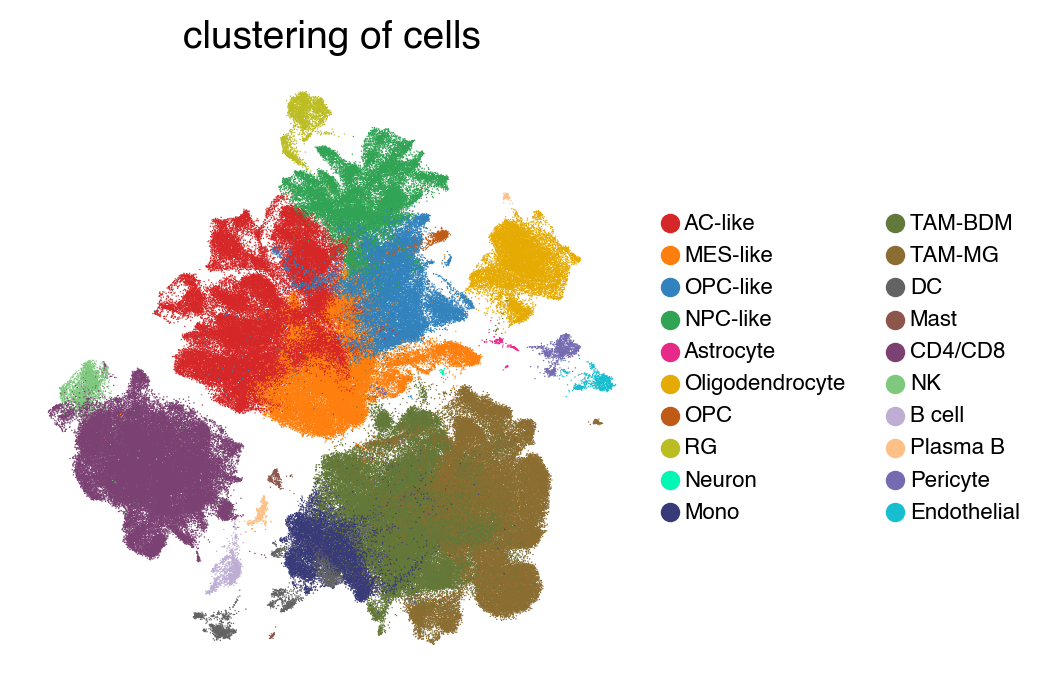

In [ ]:
sc.pl.umap(adata, color='cell_type', legend_loc='right margin',
           legend_fontsize=8, legend_fontoutline=2,frameon=False,
           title='clustering of cells', size = 1, palette=['#d62728', '#ff7f0e', '#3182bd','#31a354',
                '#e7298a','#e6ab02', '#bf5b17','#bcbd22','#00F6B3',
                '#393b79','#637939','#8c6d31','#636363','#8c564b',
                '#7b4173', '#7fc97f','#beaed4','#fdc086',
                '#756bb1','#17becf'])

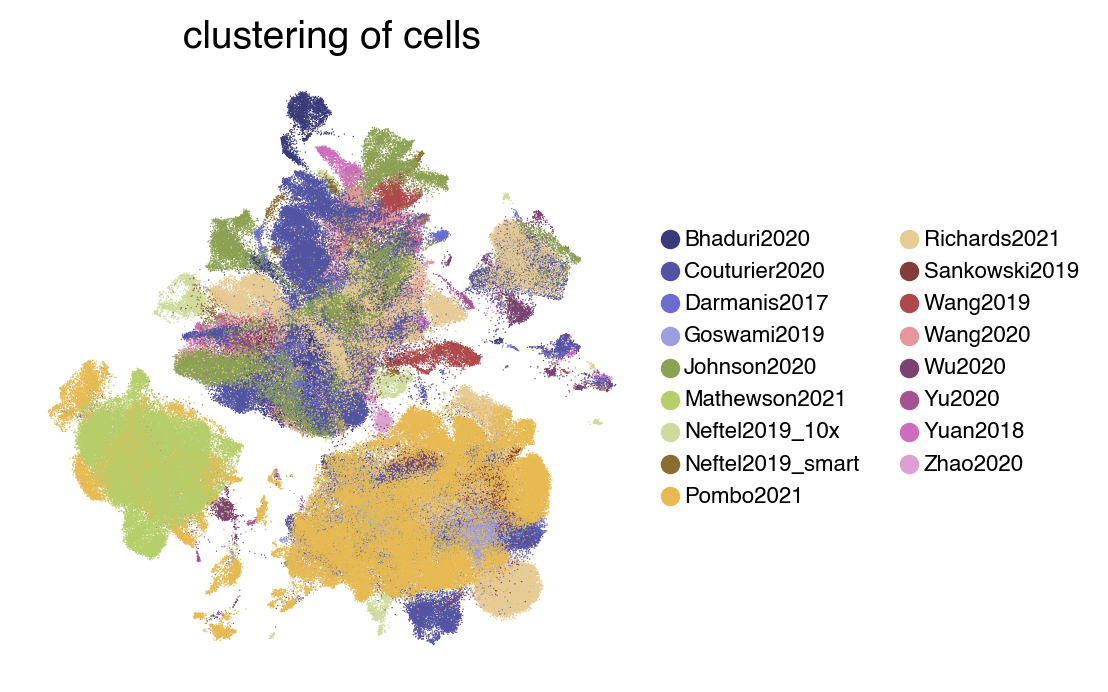

In [ ]:
sc.pl.umap(adata, color='author', legend_loc='right margin',
           legend_fontsize=8, legend_fontoutline=2,frameon=False,
           title='clustering of cells', palette = 'tab20b',size = 1)

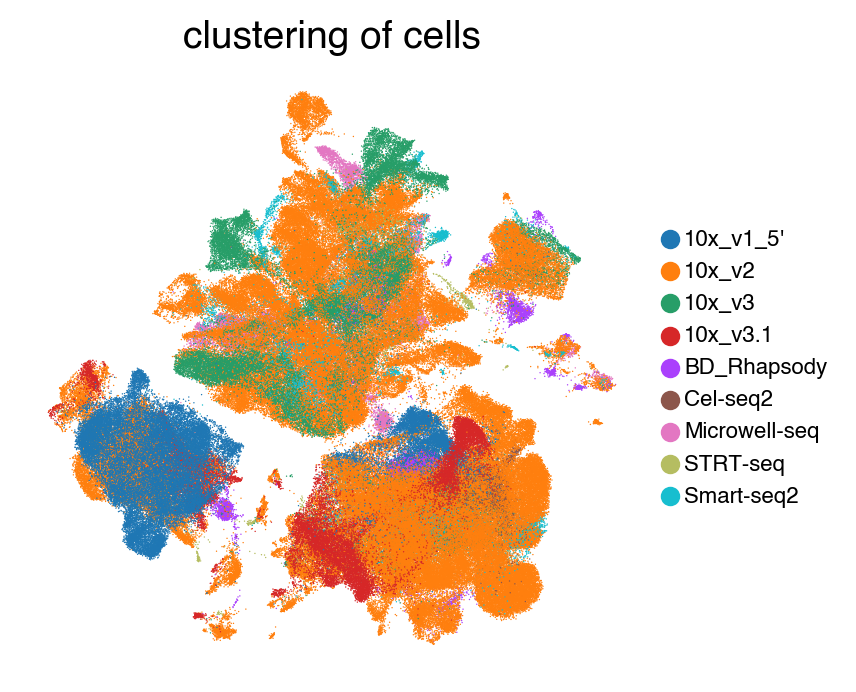

In [ ]:
sc.pl.umap(adata, color='platform', legend_loc='right margin',
           legend_fontsize=8, legend_fontoutline=2,frameon=False,
           title='clustering of cells', size = 1)

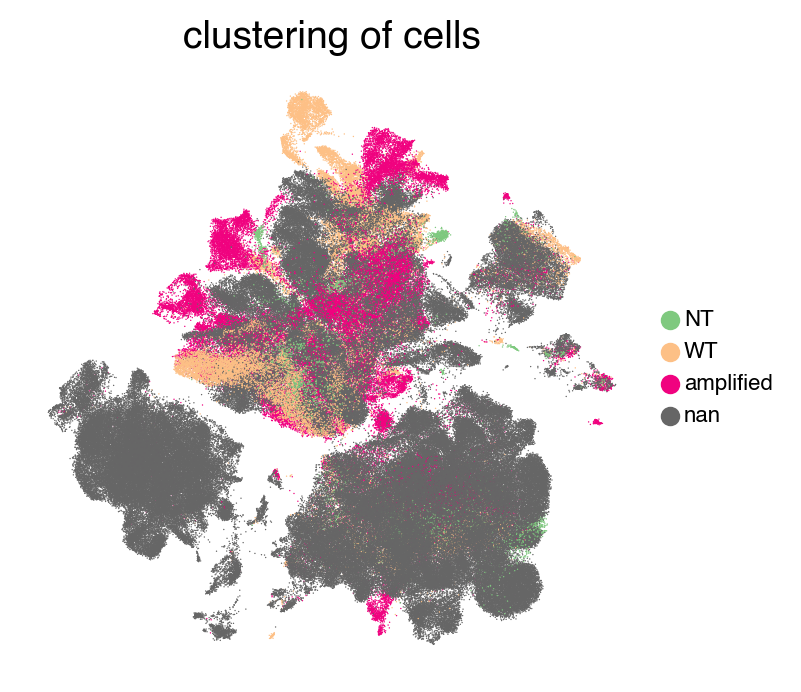

In [ ]:
adata.obs['EGFR_status'] = adata.obs['EGFR']
sc.pl.umap(adata, color='EGFR_status', legend_loc='right margin',
           legend_fontsize=8, legend_fontoutline=2,frameon=False,
           title='clustering of cells', palette = 'Accent', size = 1)

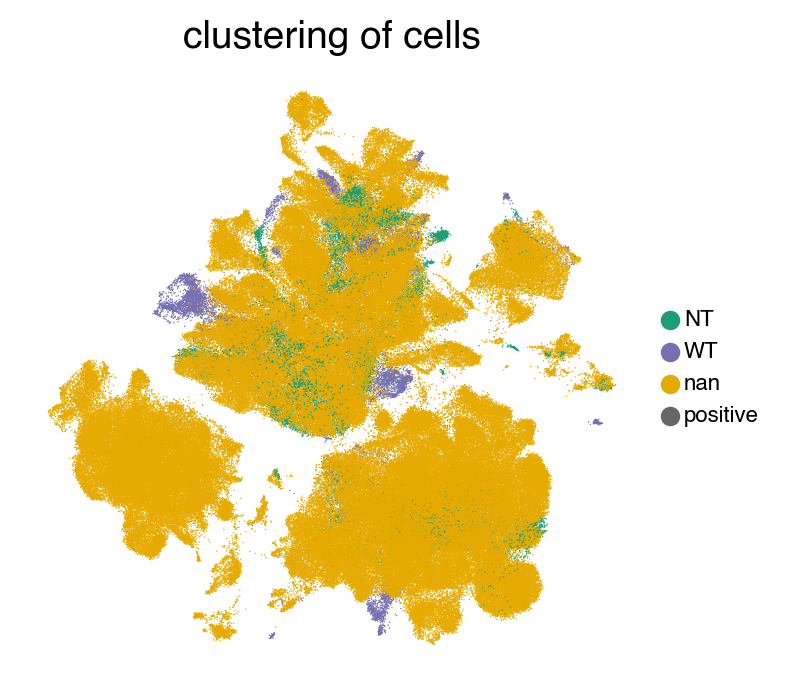

In [ ]:
adata.obs['MET_status'] = adata.obs['MET']
sc.pl.umap(adata, color='MET_status', legend_loc='right margin',
           legend_fontsize=8, legend_fontoutline=2,frameon=False,
           title='clustering of cells', palette = 'Dark2', size = 1)

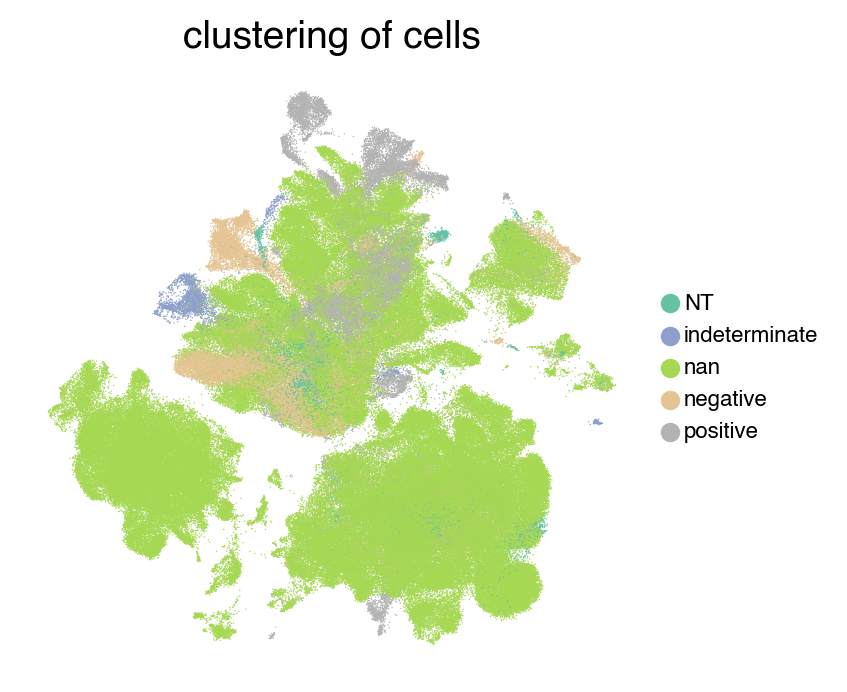

In [ ]:
sc.pl.umap(adata, color='p53', legend_loc='right margin',
           legend_fontsize=8, legend_fontoutline=2,frameon=False,
           title='clustering of cells', palette = 'Set2', size = 1)

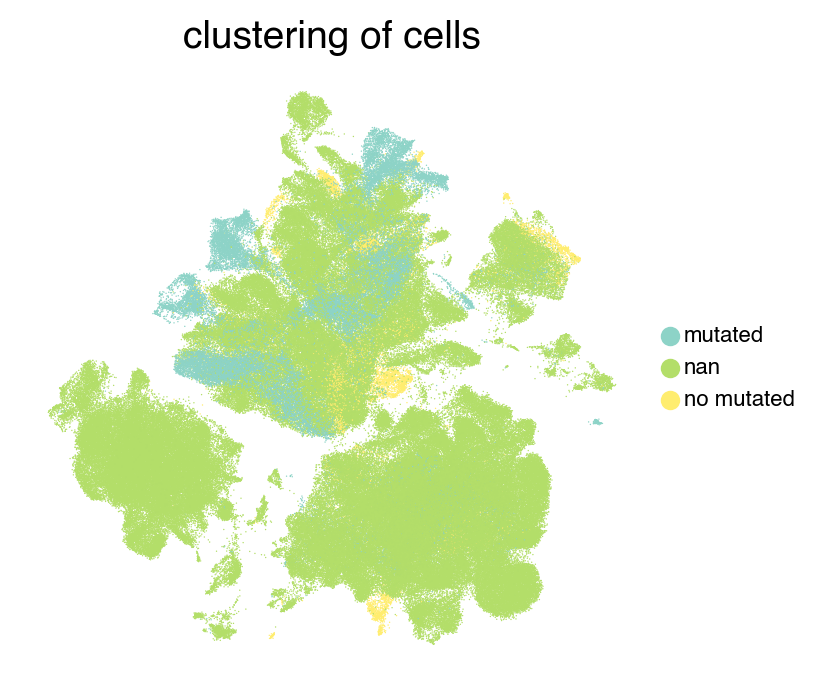

In [ ]:
sc.pl.umap(adata, color='TERT', legend_loc='right margin',
           legend_fontsize=8, legend_fontoutline=2,frameon=False,
           title='clustering of cells', palette = 'Set3', size = 1)

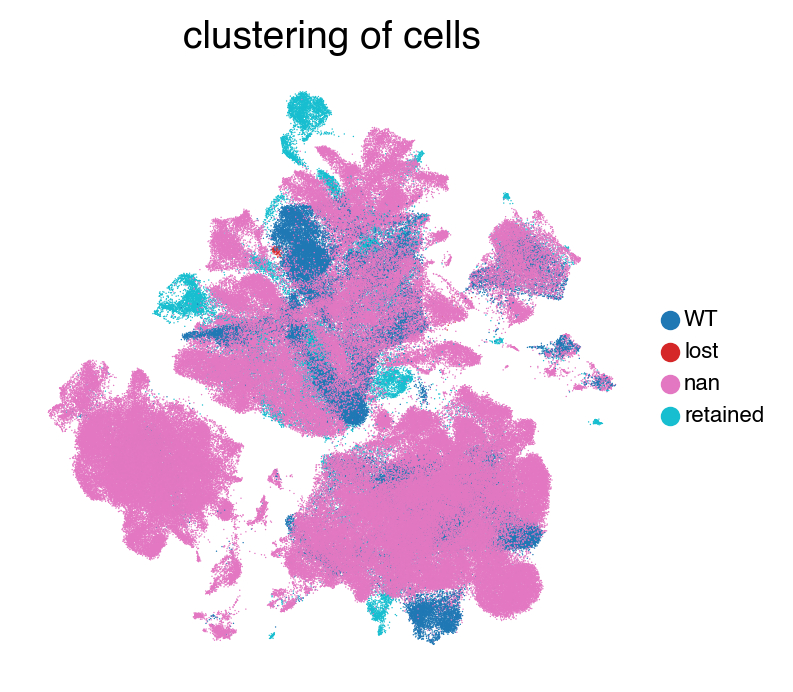

In [ ]:
sc.pl.umap(adata, color='ATRX', legend_loc='right margin',
           legend_fontsize=8, legend_fontoutline=2,frameon=False,
           title='clustering of cells', palette = 'tab10', size = 1)

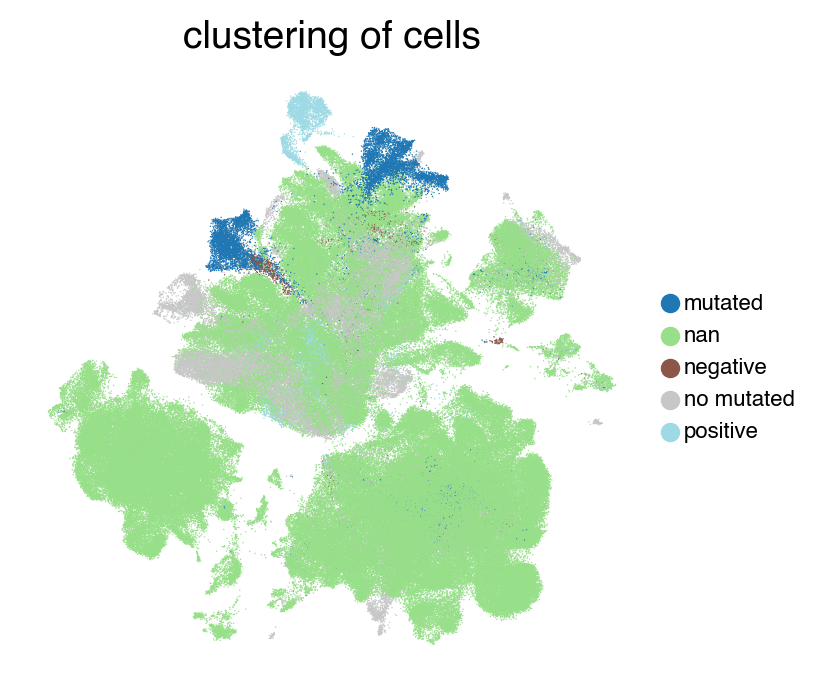

In [ ]:
sc.pl.umap(adata, color='PTEN', legend_loc='right margin',
           legend_fontsize=8, legend_fontoutline=2,frameon=False,
           title='clustering of cells', palette = 'tab20', size = 1)

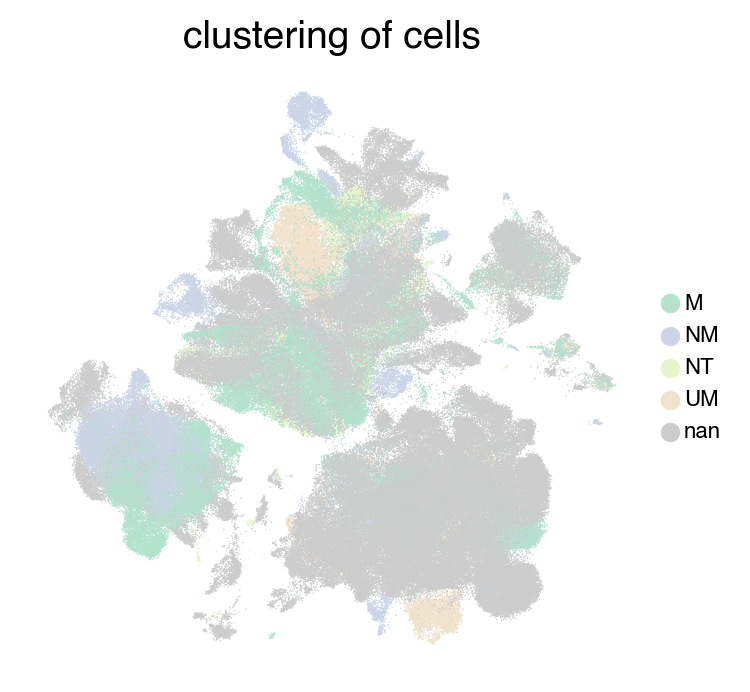

In [ ]:
adata.obs['MGMT_status'] = adata.obs['MGMT']
sc.pl.umap(adata, color='MGMT_status', legend_loc='right margin',
           legend_fontsize=8, legend_fontoutline=2,frameon=False,
           title='clustering of cells', palette = 'Pastel2', size = 1)

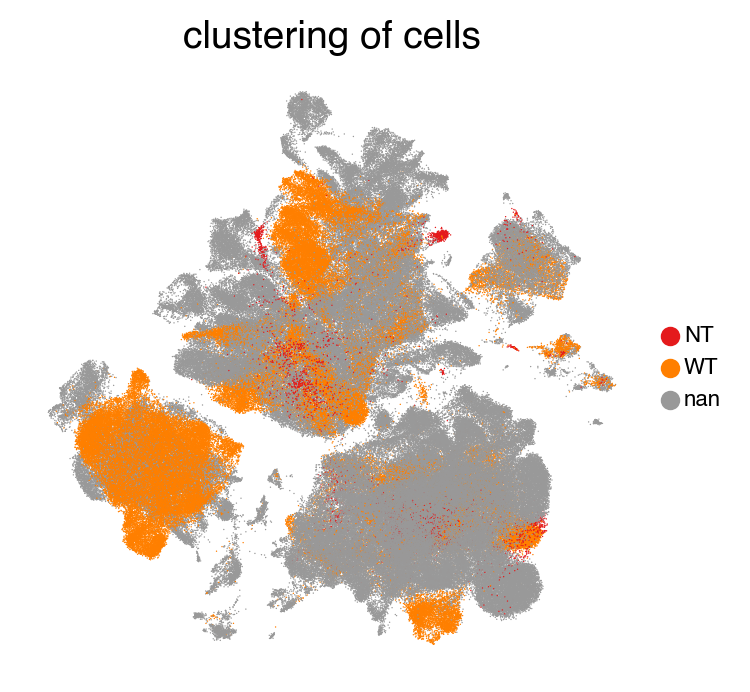

In [ ]:
sc.pl.umap(adata, color='chr1p19q', legend_loc='right margin',
           legend_fontsize=8, legend_fontoutline=2,frameon=False,
           title='clustering of cells', palette = 'Set1', size = 1)

/hpc/pmc_stunnenberg/cruiz/miniconda3/envs/python_pHGG_project/lib/python3.7/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/hpc/pmc_stunnenberg/cruiz/miniconda3/envs/python_pHGG_project/lib/python3.7/site-packages/plotnine/geoms/geom_polygon.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/hpc/pmc_stunnenberg/cruiz/miniconda3/envs/python_pHGG_project/lib/python3.7/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/hpc/pmc_stunnenberg/cruiz/miniconda3/envs/python_pHGG_project/lib/python3.7/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be remo

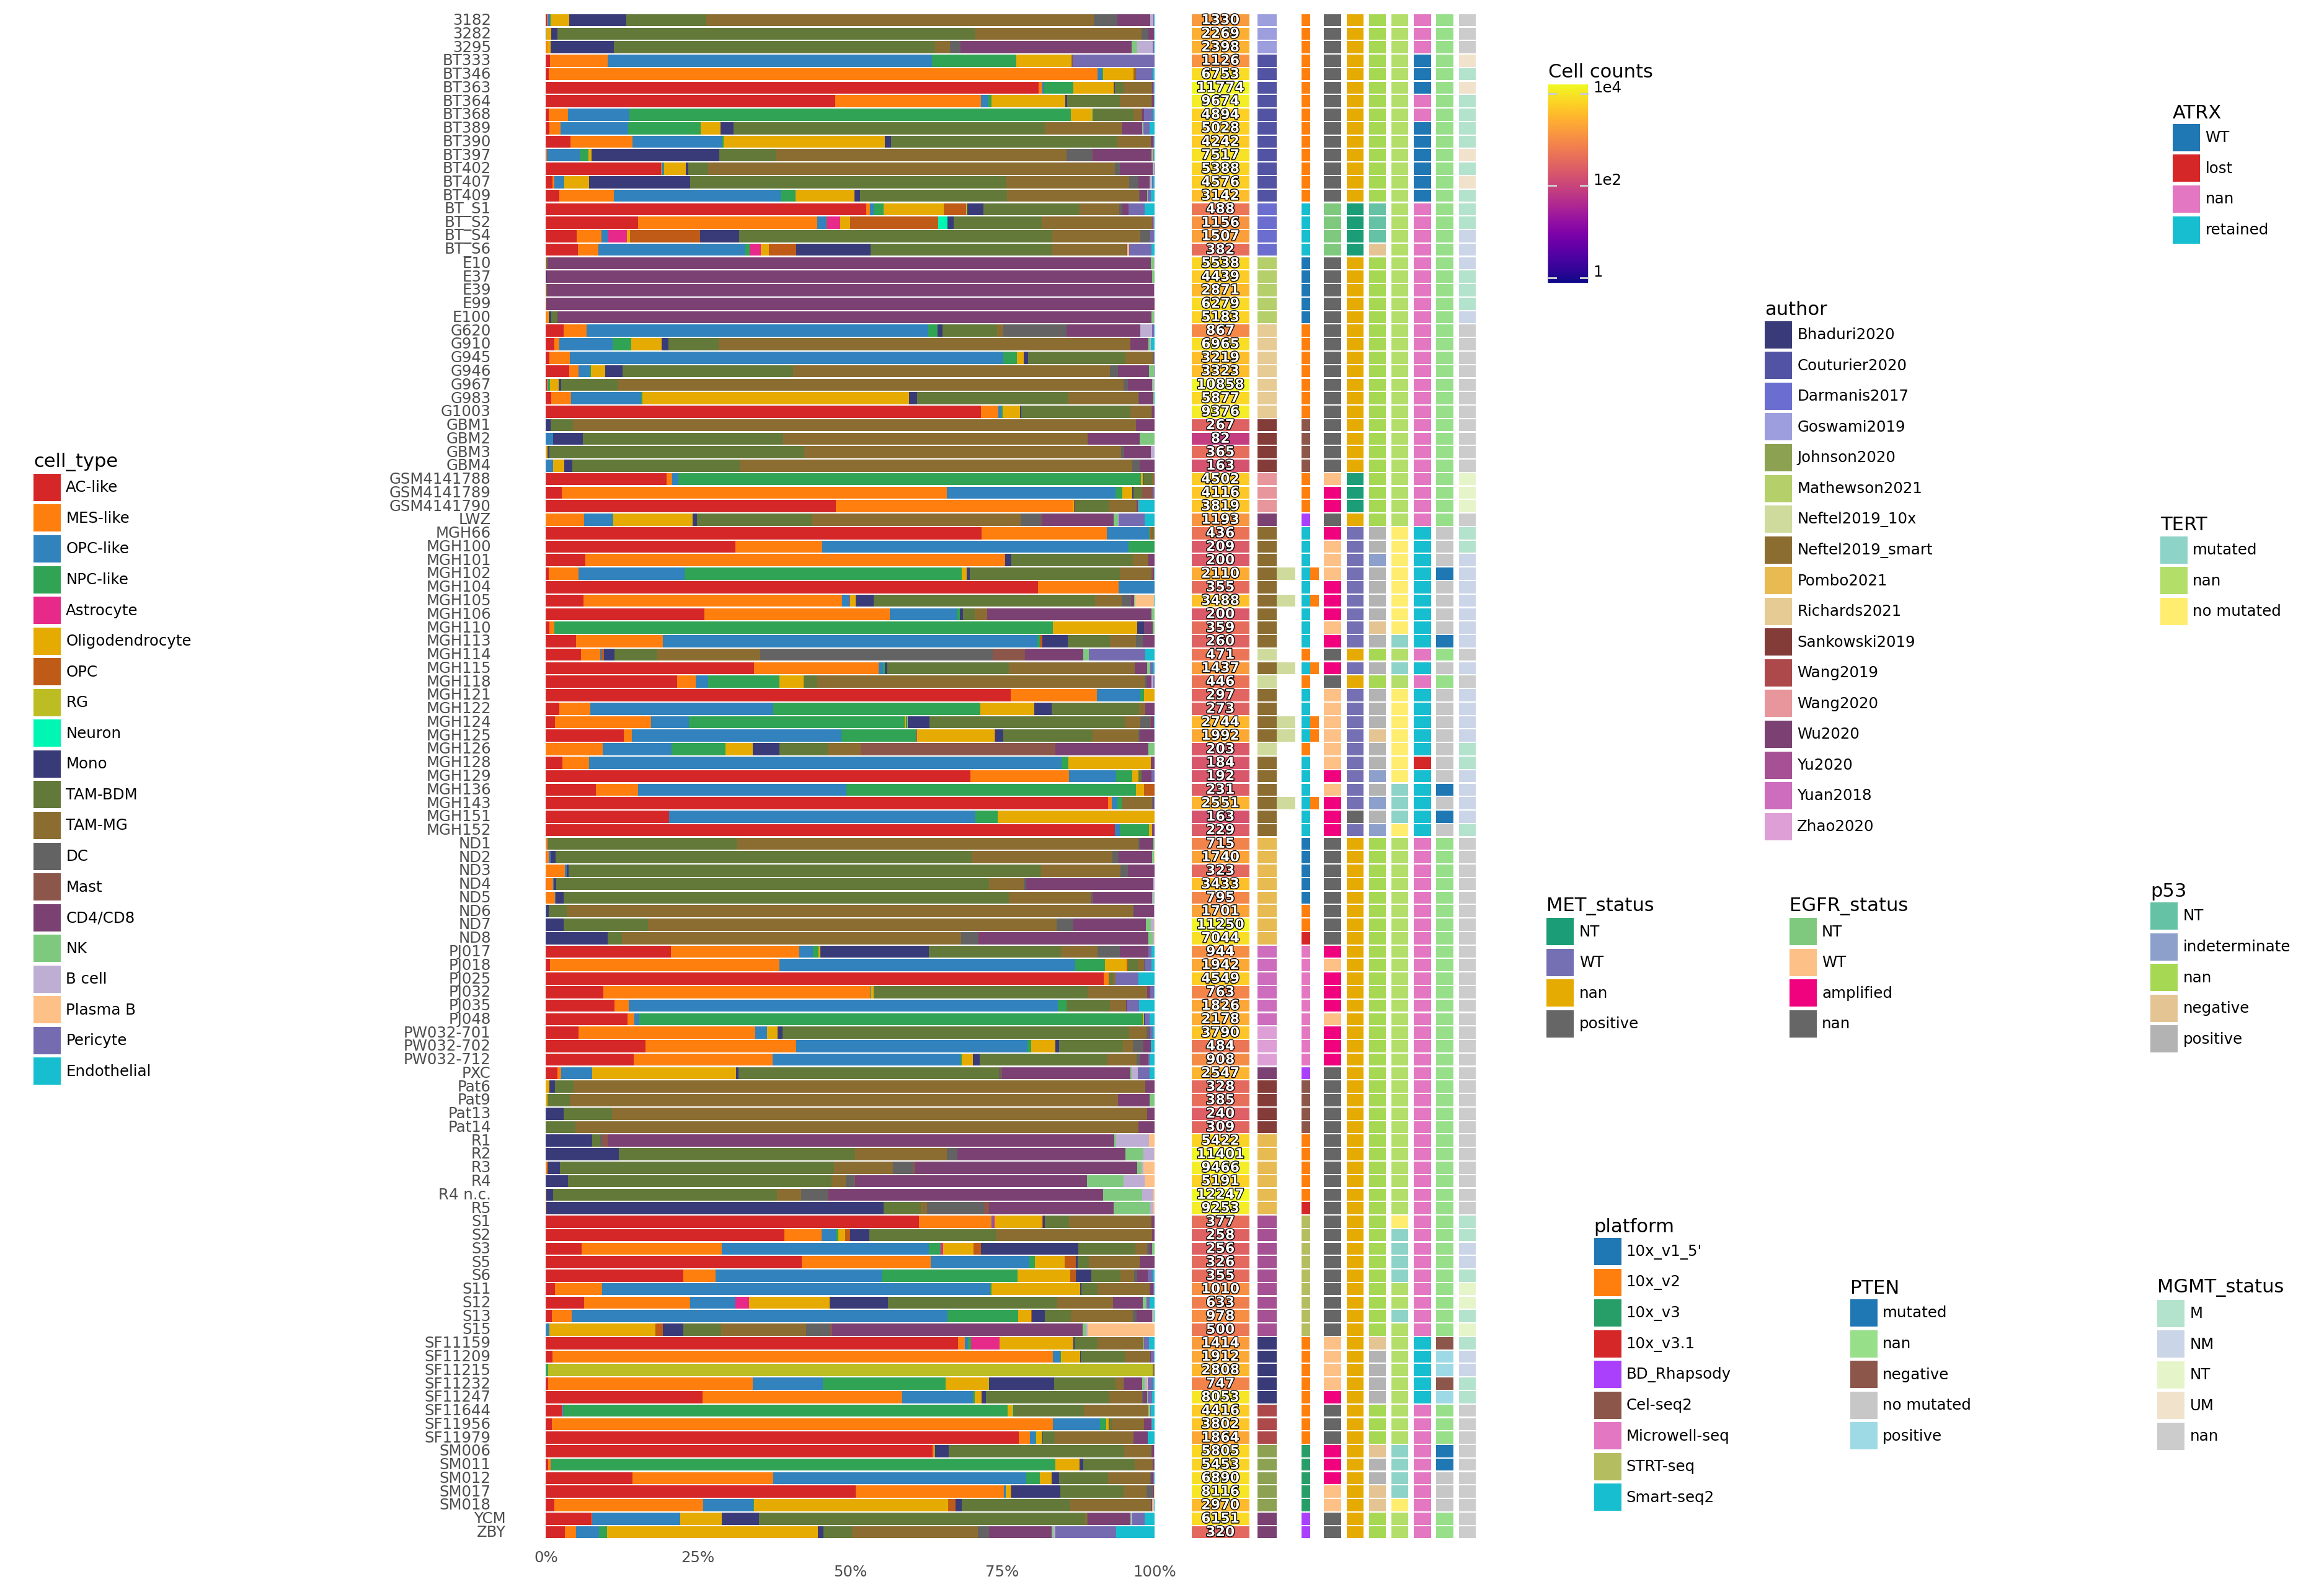

In [ ]:
f1 = plot_proportion_barplot(adata, 'patient', 'cell_type', legend_position=(-0.2,0.5), 
                             height_scale=0.8, percent_limit=10, show_percent=False)
f2 = plot_proportion_barplot_cellcounts(adata, 'patient', legend_position=(1,0.8))
f3 = plot_proportion_barplot_single_categorical(adata, 'patient', 'author', legend_position=(1.2,0.6))
f4 = plot_proportion_barplot_single_categorical(adata, 'patient', 'platform', legend_position=(1.05,0.2))
f5 = plot_proportion_barplot_single_categorical(adata, 'patient', 'EGFR_status', legend_position=(1.2,0.4))
f6 = plot_proportion_barplot_single_categorical(adata, 'patient', 'MET_status', legend_position=(1,0.4))
f7 = plot_proportion_barplot_single_categorical(adata, 'patient', 'p53', legend_position=(1.5,0.4))
f8 = plot_proportion_barplot_single_categorical(adata, 'patient', 'TERT', legend_position=(1.5,0.6))
f9 = plot_proportion_barplot_single_categorical(adata, 'patient', 'ATRX', legend_position=(1.5,0.8))
f10 = plot_proportion_barplot_single_categorical(adata, 'patient', 'PTEN', legend_position=(1.25,0.2))
f11 = plot_proportion_barplot_single_categorical(adata, 'patient', 'MGMT_status', legend_position=(1.5,0.2))


f = merge_ggplots(f1, f2, f3, f4, f5,f6, f7, f8, f9, f10, f11, 
                  units=[30, 3, 2, 1,1,1,1,1,1,1,1], figsize=(10,16))
f.savefig( sc.settings.figdir / 'Figure-celltype-compositions.pdf', bbox_inches = "tight")

Plot was finally tidied up in Illustrator